In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K

import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

# seeding for reproducible results
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

matplotlib.rcParams['figure.figsize'] = (24, 18)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams.update({'font.size': 20})

TRAIN_SIZE = 9800
TRAIN_TIME = 6
BATCH_SIZE = 32
BUFFER_SIZE = 500

In [4]:
total_ped_matrix = np.load("../details/ego_ped_matrix.npy")

with open("../details/ped_dataset.pkl", "rb") as f:
    ped_dataset = pickle.load(f)
    
with open('../details/scene_info.pkl', 'rb') as handle:
    scene_info = pickle.load(handle)

In [3]:
# Init NuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

In [5]:
nusc = NuScenes(version='v1.0-trainval', \
                dataroot='../../../../../data/', \
                verbose=False)

In [6]:
so_map = NuScenesMap(dataroot='../../../../../data/', \
                       map_name='singapore-onenorth')
bs_map = NuScenesMap(dataroot='../../../../../data/', \
                       map_name='boston-seaport')
sh_map = NuScenesMap(dataroot='../../../../../data/', \
                       map_name='singapore-hollandvillage')
sq_map = NuScenesMap(dataroot='../../../../../data/', \
                       map_name='singapore-queenstown')

# dict mapping map name to map file
map_files = {'singapore-onenorth': so_map,
             'boston-seaport': bs_map,
             'singapore-hollandvillage': sh_map,
             'singapore-queenstown': sq_map}

In [5]:
# # calculating the values for standardization for every feature
# mean_values = np.mean(total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :], axis=(0,1))
# std_values = np.std(total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :], axis=(0,1))

# # standardization
# total_ped_matrix = (total_ped_matrix - mean_values) / std_values

In [5]:
# train_test split
x_train = total_ped_matrix[:TRAIN_SIZE, :, :TRAIN_TIME, :]
x_train = x_train.reshape(TRAIN_SIZE, 84)
y_train1 = total_ped_matrix[:TRAIN_SIZE, 0, TRAIN_TIME:, :2]
y_train2 = total_ped_matrix[:TRAIN_SIZE, 1, TRAIN_TIME:, :2]
# shape is 9800,20,2
y_train = np.append(y_train1, y_train2, axis=1)
y_train= y_train.reshape(TRAIN_SIZE, 40)

x_test = total_ped_matrix[TRAIN_SIZE:, :, :TRAIN_TIME, :]
x_test = x_test.reshape(len(total_ped_matrix)-TRAIN_SIZE, 84)
y_test1 = total_ped_matrix[TRAIN_SIZE:, 0, TRAIN_TIME:, :2]
y_test2 = total_ped_matrix[TRAIN_SIZE:, 1, TRAIN_TIME:, :2]
y_test = np.append(y_test1, y_test2, axis=1)
y_test = y_test.reshape(len(total_ped_matrix)-TRAIN_SIZE, 40)

In [6]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [7]:
# defining the custom rmse loss function
def ttc_loss(pred_path, ego_path):
    tot_loss = 0.0
    for i in range(pred_path.shape[0]):
        del_time = 0.0
        del_dist = np.inf
        for j in range(pred_path.shape[1]):
            for k in range(ego_path.shape[1]):
                pred_pos = pred_path[i,j,:]
                ego_pos = ego_path[i,k,:]
                
                dist = np.sqrt(np.sum((pred_pos - ego_pos)**2))
                if dist < del_dist:
                    del_dist = dist
                    del_time = abs(j-k)
                    
        tot_loss += del_time
    return np.float32(tot_loss/float(len(pred_path)))  

def model_loss(gt, pred):
    '''
    calculates custom rmse loss between every time point
    '''
    pred_path = tf.reshape(pred, [-1,10,2])
    gt_path = gt[:,:20]
    gt_path = tf.reshape(gt_path, [-1,10,2])
    
    rmse_error = K.mean(K.sqrt(K.sum(K.square(gt_path-pred_path), axis=1)))
    
    ego_path = gt[:,20:]
    ego_path = tf.reshape(ego_path, [-1,10,2])
    
    ttc_error = tf.numpy_function(ttc_loss, [pred_path, ego_path], tf.float32)
    return rmse_error

def euc_dist(gt, pred):
    # custom metric to monitor rmse
    gt = gt[:,:20]
    gt_path = tf.reshape(gt, [-1,10,2])
    pred_path = tf.reshape(pred, [-1,10,2])
    rmse = K.mean(K.sqrt(K.sum(K.square(gt_path - pred_path), axis=1)))
    return rmse

In [8]:
# defining the model
fc_model = tf.keras.models.Sequential()
fc_model.add(tf.keras.layers.Input(shape=(x_train.shape[1],)))
fc_model.add(tf.keras.layers.Dense(64, activation='relu'))
fc_model.add(tf.keras.layers.Dense(48, activation='relu'))
fc_model.add(tf.keras.layers.Dense(20, activation='linear'))

fc_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), 
                 loss=model_loss, 
                 metrics=[euc_dist])

In [9]:
fc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                5440      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                3120      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                980       
Total params: 9,540
Trainable params: 9,540
Non-trainable params: 0
_________________________________________________________________


In [10]:
# checkpoint for saving the best model
filepath="../checkpoints/mlp_ego.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_euc_dist', 
                                                verbose=1, save_best_only=True, 
                                                save_weights_only=False,
                                                mode='min')
callbacks_list = [checkpoint]

train_history = fc_model.fit(train_data, epochs=40,
                             verbose=0, callbacks=callbacks_list,
                             validation_data=val_data,
                             steps_per_epoch=400,
                             validation_steps=70
                             )


Epoch 00001: val_euc_dist improved from inf to 1.42251, saving model to ../checkpoints/mlp_ego.hdf5

Epoch 00002: val_euc_dist improved from 1.42251 to 1.04807, saving model to ../checkpoints/mlp_ego.hdf5

Epoch 00003: val_euc_dist improved from 1.04807 to 0.82755, saving model to ../checkpoints/mlp_ego.hdf5

Epoch 00004: val_euc_dist improved from 0.82755 to 0.79999, saving model to ../checkpoints/mlp_ego.hdf5

Epoch 00005: val_euc_dist did not improve from 0.79999

Epoch 00006: val_euc_dist improved from 0.79999 to 0.63647, saving model to ../checkpoints/mlp_ego.hdf5

Epoch 00007: val_euc_dist did not improve from 0.63647

Epoch 00008: val_euc_dist did not improve from 0.63647

Epoch 00009: val_euc_dist improved from 0.63647 to 0.60594, saving model to ../checkpoints/mlp_ego.hdf5

Epoch 00010: val_euc_dist did not improve from 0.60594

Epoch 00011: val_euc_dist did not improve from 0.60594

Epoch 00012: val_euc_dist did not improve from 0.60594

Epoch 00013: val_euc_dist improved fr

In [11]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

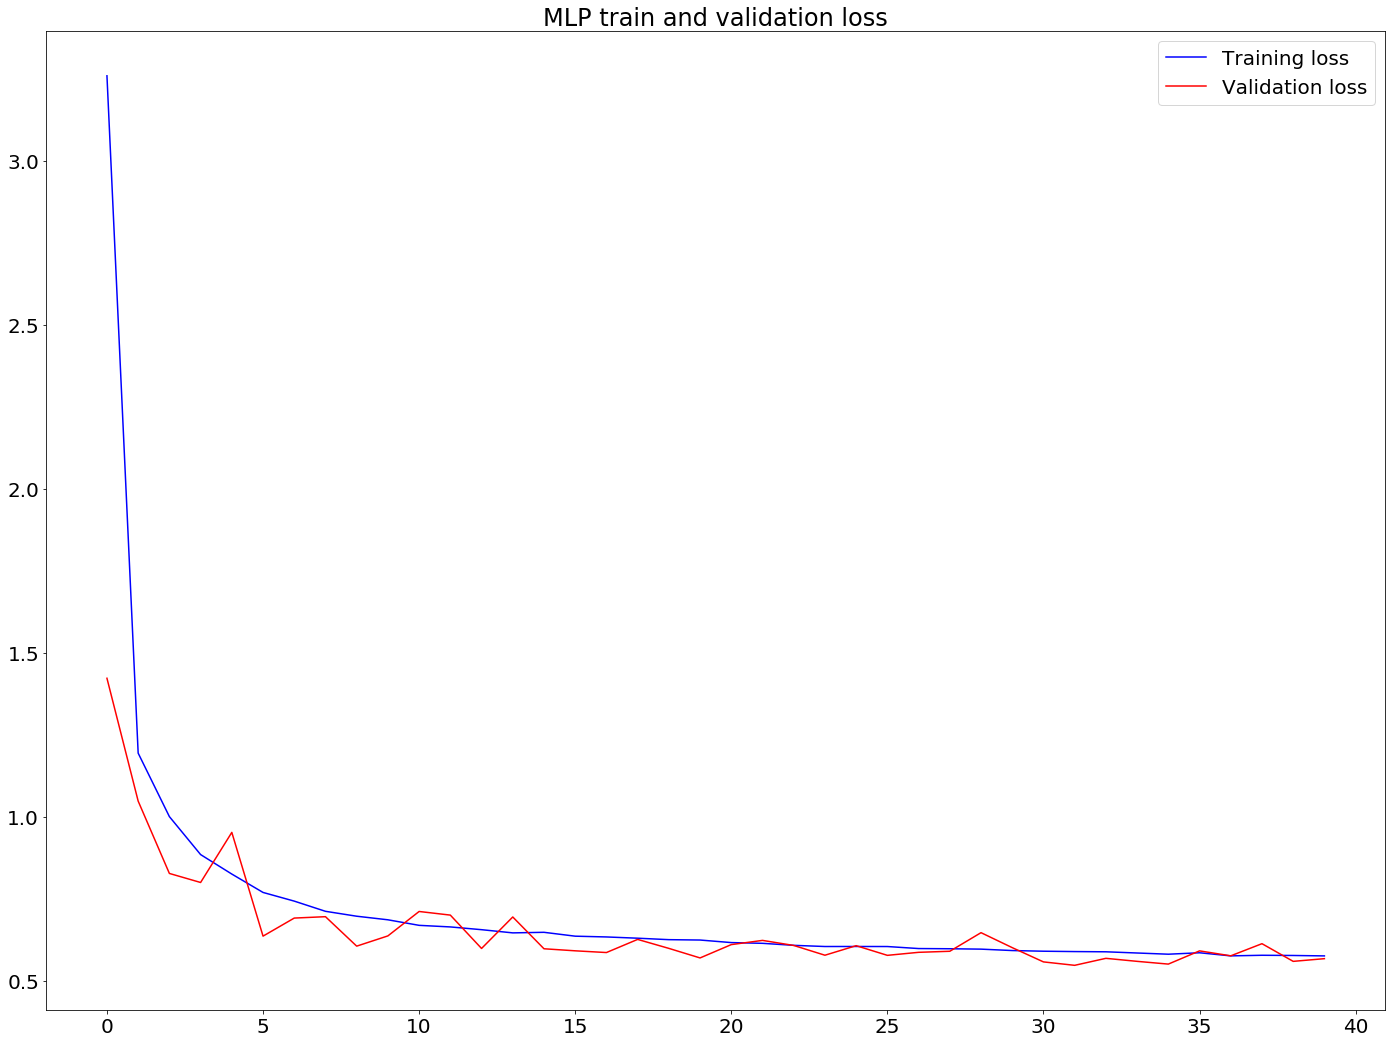

In [12]:
plot_train_history(train_history, "MLP train and validation loss")

In [13]:
# undo normalization for plotting
def move_from_origin(l, origin):
    x0, y0 = origin
    return [[x + x0, y + y0] for x, y in l]

def rotate_from_y(l, angle):
    theta = -angle
    return [(x*np.cos(theta) - y*np.sin(theta), 
                    x*np.sin(theta) + y*np.cos(theta)) for x, y in l]

# loss calculation for test prediction
def rmse_error(l1, l2):
    loss = 0.0
    
    if len(np.array(l1).shape) < 2:
        return ((l1[0] - l2[0])**2 + (l1[1] - l2[1])**2)**0.5
    for p1, p2 in zip(l1, l2):
        loss += ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5
    return (loss / float(len(l1))) 

In [14]:
ade_values = []
fde_values = []

for test_idx in range(TRAIN_SIZE, len(ped_dataset)):
    test_data = np.reshape(total_ped_matrix[test_idx,:,:6,:]
                           , (1, 84))
    predictions = fc_model.predict(test_data).reshape(-1, 2)
    predictions = move_from_origin(rotate_from_y(predictions, ped_dataset[test_idx]["angle"]),
                                   ped_dataset[test_idx]["origin"])

#     n_scene = ped_dataset[test_idx]["scene_no"]
#     ego_poses = map_files[scene_info[str(n_scene)]["map_name"]].render_egoposes_on_fancy_map(
#                     nusc, scene_tokens=[nusc.scene[n_scene]['token']], verbose=False,
#                     render_egoposes=True, render_egoposes_range=False, 
#                     render_legend=False)

#     plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[:6,:2]), c='k', s=5, zorder=2)
#     plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[6:,:2]), c='b', s=5, zorder=3)
#     plt.scatter(*zip(*predictions), c='r', s=5, zorder=4)
#     plt.show()
    
    loss = rmse_error(predictions, np.array(ped_dataset[test_idx]["translation"])[6:,:2])
        
    final_loss = rmse_error(predictions[-1], 
                            np.array(ped_dataset[test_idx]["translation"])[-1,:2])

    
#     print(f"Loss in m is {loss}")
#     print(f"Loss of final position in m is {final_loss}")
    
    ade_values.append(loss)
    fde_values.append(final_loss)
    
print(np.mean(np.array(ade_values)))
print(np.mean(np.array(fde_values)))

0.25618765147305556
0.489877858947206
